<a href="https://colab.research.google.com/github/qmcsuzuki/QMCexamples/blob/main/QMCintegration/QMC_expsum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qmcpy --quiet
import qmcpy
import numpy as np
from matplotlib import pyplot as plt

## 実験の目的

被積分関数を $f(x) = \exp\left(\sum_{j=1}^s  w_jx_j\right)$ とする。
次元 $s$ が大きくてもQMC 積分の誤差がちゃんと収束するか、次の重みの設定で観察する

- $w_j=1$ （等方的）
- $w_j=1/j^2$ （重み付き）

点列としては、（ランダムネスなしの）Sobol', Halton を使う

---

以下、必要な関数を定義する


In [2]:
def expsum(points,weights,C):
    """
    Args:
      points: N*d ndarray, points to evaluate
      weights: d-dim vector, weights for each dimension
      C: (normalization) constant
    Returns: N-dim vector, exp(sum(w1*x1+...+ws*xs))/C for each point
    """
    return np.exp(np.sum(points*weights,1))/C

def make_normalized_expsum(weights):
    C = np.prod((np.exp(weights)-1)/weights)
    return lambda points: expsum(points,weights,C)


In [3]:
def make_errortable(integrand, Points, Mmax, truevalue=1):
    """ Points の最初の 2^1, ..., 2^{Mmax} 点での，integrand のQMC積分誤差のテーブルを返す
    integrand: 被積分関数
    Points: N*d ndarray (d-dimensional N points)
    """
    error = np.zeros(Mmax)
    for m in range(1,Mmax+1):
        x = np.mean(integrand(Points[:1<<m,:]))
        error[m-1] = np.abs(x-truevalue)
    return error


def make_errorplot(Errors, labels, slopes, savefilename):
    """ Errors の各 Error 配列の中身を loglog プロットする
    Errors: 長さ Mmax の配列のリスト
    labels: 名前のリスト
    slopes: 凡例に表示する傾き
    """
    plt.figure(figsize=(10, 6))
    linestyles = ['-', '--',  ':', '-.']
    markers = ['o', '^', 'x', 'D']

    for i,error in enumerate(Errors):
        plt.semilogy(np.arange(1,Mmax+1), error, color='black', linestyle=linestyles[i], marker=markers[i], markerfacecolor='none', label=labels[i])

    for slope in slopes:
        x = np.arange(1, Mmax+1)
        y = 2.0**(slope*x)
        plt.semilogy(x, y, color='gray', linestyle='--', label=f'Slope={slope}')

    plt.xticks(np.arange(1, Mmax+1, 2),fontsize=16)  # X軸の目盛りを2刻みに
    plt.yticks(fontsize=16)  # Y軸の目盛りを大きく
    plt.xlim(0,Mmax+0.1)
    plt.ylim(10**-6, 10**0)  # Y軸の範囲を固定
    plt.legend(fontsize=16)

    plt.savefig(savefilename,format="pdf",bbox_inches='tight')
    plt.show()


In [4]:
def experiment(s,Mmax,weights,randomize,savefilename):
    """
    被積分関数 f(x)=exp(sum(w[j]*x[j]))  とする
    Sobol, Halton, Random による積分誤差をプロットする
    """
    sobol = qmcpy.Sobol(dimension=s,randomize=randomize).gen_samples(1<<Mmax)
    halton = qmcpy.Halton(dimension=s,randomize=randomize).gen_samples(1<<Mmax)
    random = qmcpy.IIDStdUniform(dimension=s).gen_samples(1<<Mmax)

    samplers = [sobol,halton,random]
    integrand = make_normalized_expsum(weights)

    labels = ["Sobol'",'Halton','Random']
    Errors = [make_errortable(integrand, points, Mmax) for points in (sobol,halton,random)]
    make_errorplot(Errors, labels, slopes=[-1,-0.5],savefilename=savefilename)


---

以下、重みを $w = [1,1,\dots,1]$ として実験する

/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:332
/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/halton.py:270


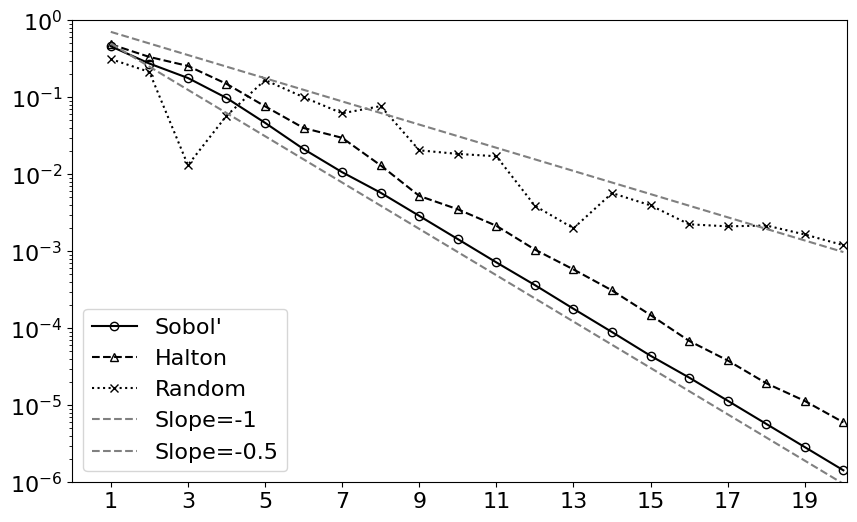

In [5]:
s = 3
Mmax = 20
weights = np.ones(s)
savefilename=f"{s}dim-unweighted"

experiment(s,Mmax,weights,False,savefilename)

## 実験結果

$w_j=1$ （等方的 ）なときは

- $s =3,6$ なら$O(N^{-1})$の収束がはっきり見える
- $s=10$ ならサンプル点の個数を増やせば$O(N^{-1})$に漸近する
- $s=20$ では、$N=2^{20}$ でもモンテカルロ法と大差ない

---



以下、重みを $w = [1,1/4,\dots,1/s^2]$ として実験する

/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:332
/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/halton.py:270


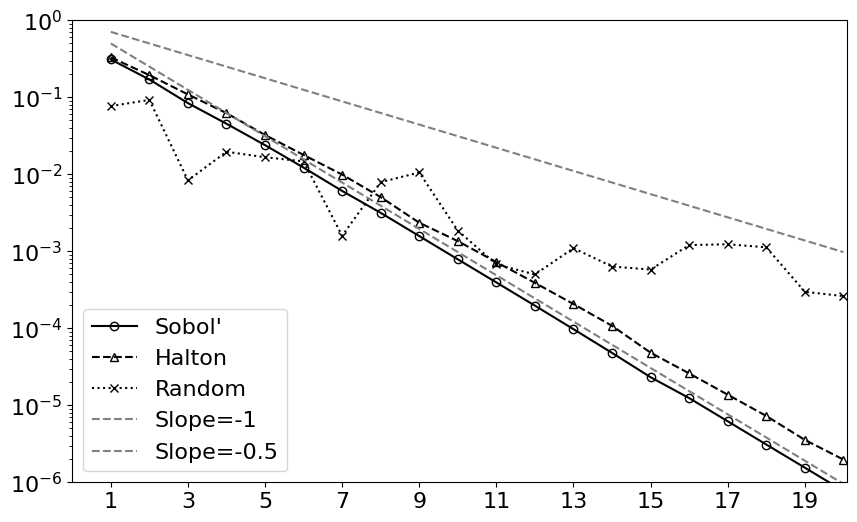

In [6]:
s = 50
Mmax = 20
weights = 1/np.arange(1,s+1)**2
savefilename=f"{s}dim-weighted"

experiment(s,Mmax,weights,False,savefilename)



## 実験結果

$w_j=1/j^2$ （重み付き）なときは

- $s=20,99$ でも $O(N^{-1})$ の収束がはっきりと見えた
